In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV

In [22]:
data = pd.read_csv('maladie_cardiaque.csv', usecols=lambda column: column != 'Unnamed: 0',index_col = 'id')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                70000 non-null  int64  
 1   genre              70000 non-null  object 
 2   taille             70000 non-null  int64  
 3   Poids              70000 non-null  float64
 4   pression_systo     70000 non-null  int64  
 5   pression_diasto    70000 non-null  int64  
 6   cholesterol        70000 non-null  object 
 7   glycemie           70000 non-null  int64  
 8   fumeur             70000 non-null  object 
 9   conso_alco         70000 non-null  object 
 10  activite_physique  70000 non-null  int64  
 11  malade             70000 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 6.9+ MB


In [24]:
def transform_dataframe(data):
    # Ajouter une colonne 'age_annee'
    data["age_annee"] = round(data["age"]/365.25,2)

    # Créer les intervalles pour les classes d'âge
    bins = [0, 18, 30, 45, 60, 100]

    # Créer les étiquettes pour les classes d'âge
    labels = ['moins de 18 ans', '18-30 ans', '30-45 ans', '45-60 ans', 'plus de 60 ans']

    # Créer une nouvelle colonne 'classe_age' en utilisant la méthode cut()
    data['classe_age'] = pd.cut(data['age_annee'], bins=bins, labels=labels)

    # Convertir les colonnes 'malade', 'fumeur' et 'conso_alco' en 0/1
    data['malade'] = data["malade"].map({'oui': 1, 'non': 0})
    data['fumeur'] = data["fumeur"].map({'fumeur': 1, 'non fumeur': 0})
    data['conso_alco'] = data["conso_alco"].map({'oui': 1, 'non': 0})

    # Ajouter une colonne 'IMC_Category'
    def imc_category(row):
        taille_m = row['taille'] / 100  # Convertir la taille en mètres
        imc = row['Poids'] / (taille_m ** 2)  # Calculer l'IMC
        if imc < 18.5:
            return 'Maigre'
        elif imc < 25:
            return 'Normal'
        elif imc < 30:
            return 'Surpoids'
        else:
            return 'Obèse'
    data['IMC'] = data.apply(lambda row: row['Poids'] / ((row['taille'] / 100) ** 2), axis=1)
    data['IMC_Category'] = data.apply(imc_category, axis=1)


    # Appliquer get_dummies sur les colonnes catégorielles
    cat_cols = data.select_dtypes(exclude=['int64', 'float64']).columns
    cat_cols = list(cat_cols)
    cat_cols.append("glycemie")
    df_onehot = pd.get_dummies(data, columns=cat_cols)

    # Supprimer les colonnes non nécessaires
    df_onehot = df_onehot.drop(['classe_age_moins de 18 ans','genre_homme', 'age_annee', 'age', 'Poids', 'taille','IMC'], axis=1)

    return df_onehot


In [25]:
df = transform_dataframe(data)

In [26]:
from sklearn.decomposition import PCA
Y = df["malade"].values
# Sélectionner les variables explicatives
X = df.drop(['malade'], axis=1)

# Instancier l'objet PCA avec le nombre de composantes principales souhaité
pca = PCA(n_components=0.95)

# Appliquer l'ACP sur les variables explicatives
X_pca = pca.fit_transform(X)



In [27]:
# Afficher les valeurs propres de chaque composante principale
print("Eigenvalues:\n", pca.explained_variance_)

# Afficher le pourcentage de variance expliqué par chaque composante principale
print("Explained variance ratio:\n", pca.explained_variance_ratio_)

# Afficher les composantes principales
print("Principal components:\n", pca.components_)


Eigenvalues:
 [35540.3381602  23701.07504811]
Explained variance ratio:
 [0.59990007 0.40006025]
Principal components:
 [[ 3.94684607e-02  9.99220806e-01  7.74576555e-06  1.27257106e-05
   1.00584417e-05 -3.90325985e-05  3.62197034e-05 -6.27835280e-05
   2.65638245e-05 -2.88088601e-08 -2.93542378e-05  1.99667980e-05
   9.41624861e-06 -4.24326996e-06 -7.55356967e-05  7.97427255e-05
   3.62411807e-08 -2.68203072e-05  1.97138132e-05  7.10649405e-06]
 [ 9.99220807e-01 -3.94684796e-02 -2.15854712e-06  1.31218348e-06
  -6.81012898e-07 -1.63102755e-05  3.22491157e-05 -6.60733511e-05
   3.38242354e-05 -2.63146235e-08 -3.84224280e-05  1.02801291e-05
   2.81686136e-05 -4.08298406e-06 -5.82169958e-05  6.01397066e-05
   2.16027328e-06 -2.83586954e-05  1.46601950e-05  1.36985004e-05]]


In [28]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print("Variance explained by each component:", var_exp)
print("Cumulative variance explained by each component:", cum_var_exp)

Variance explained by each component: [0.59990007 0.40006025]
Cumulative variance explained by each component: [0.59990007 0.99996032]


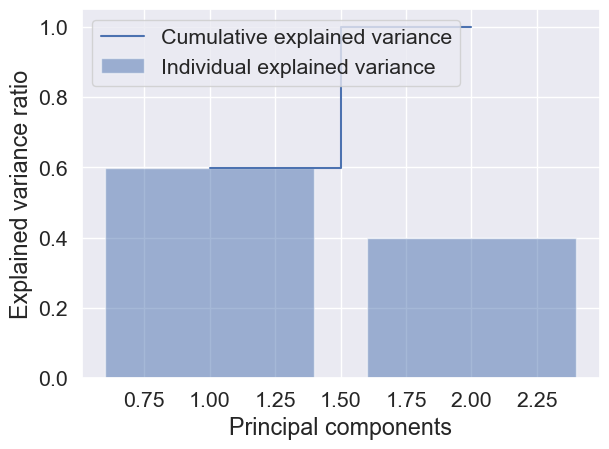

In [29]:
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
# Afficher les variables les plus importantes pour chaque composante principale
for i, component in enumerate(pca.components_, 1):
    print("Composante principale {} :".format(i))
    print([(X.columns[j], round(component[j], 4)) for j in component.argsort()[::-1][:3]])


Composante principale 1 :
[('pression_diasto', 0.9992), ('pression_systo', 0.0395), ('IMC_Category_Obèse', 0.0001)]
Composante principale 2 :
[('pression_systo', 0.9992), ('IMC_Category_Obèse', 0.0001), ('cholesterol_tres eleve', 0.0)]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.33, random_state=42)

In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
rfc.score(X_test, y_test)

0.7120779220779221

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Prédire les classes des données de test
y_pred = rfc.predict(X_test)

# Calculer l'accuracy score
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score : {:.2f}".format(acc_score))

# Calculer le F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score : {:.2f}".format(f1))

# Afficher le classification report
cr = classification_report(y_test, y_pred)
print("Classification report :")
print(cr)


Accuracy score : 0.71
F1 score : 0.71
Classification report :
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     11506
           1       0.74      0.66      0.70     11594

    accuracy                           0.71     23100
   macro avg       0.71      0.71      0.71     23100
weighted avg       0.72      0.71      0.71     23100



Matrice de confusion :


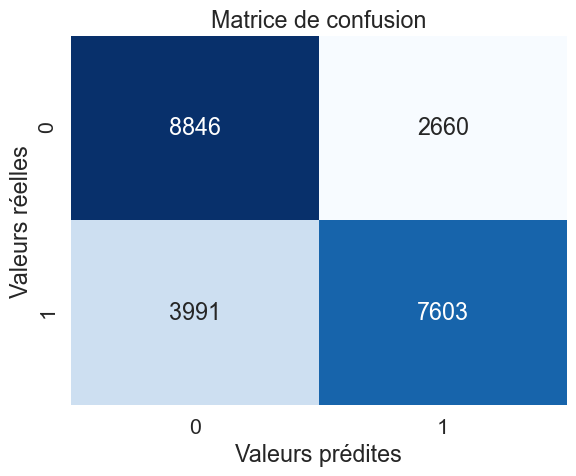

In [35]:
import seaborn as sns

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")

# Tracer la matrice de confusion avec Seaborn
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

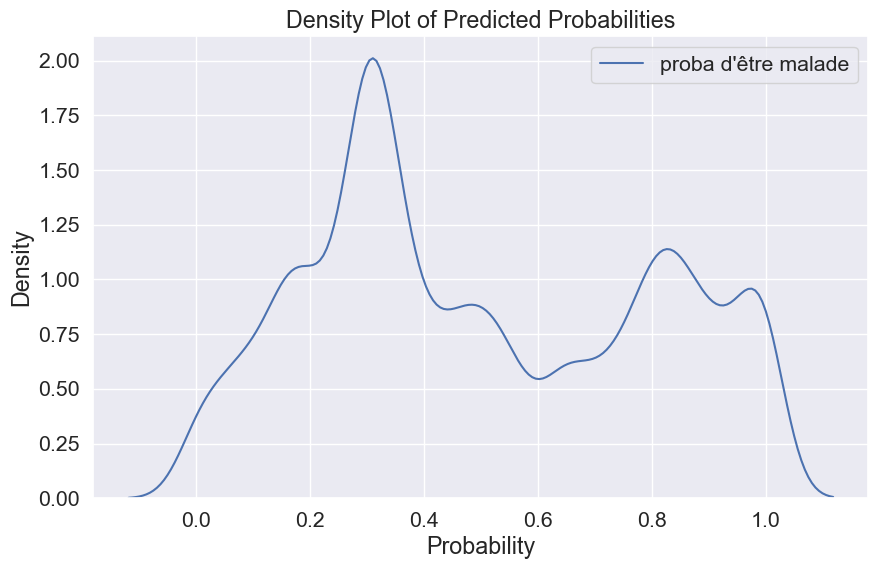

In [36]:
proba_pred  = rfc.predict_proba(X_test)


# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10,6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()

In [37]:
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None]
}

# Créer un objet GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Effectuer la recherche de grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score associé
print("Meilleurs hyperparamètres : {}".format(grid_search.best_params_))
print("Score : {:.2f}".format(grid_search.best_score_))


Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': None, 'n_estimators': 100}
Score : 0.73


In [ ]:
rfc = RandomForestClassifier(**grid_search.best_params_)
rfc.fit(X_train, y_train)

In [ ]:

# Prédire les classes des données de test
y_pred = rfc.predict(X_test)

# Calculer l'accuracy score
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score : {:.2f}".format(acc_score))

# Calculer le F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score : {:.2f}".format(f1))

# Afficher le classification report
cr = classification_report(y_test, y_pred)
print("Classification report :")
print(cr)

In [ ]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")

# Tracer la matrice de confusion avec Seaborn
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [ ]:
proba_pred  = rfc.predict_proba(X_test)


# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10,6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()

In [ ]:
import itertools

def print_nice_conf_matrix(y, cnf_matrix):
    '''
    Fonction dediee a rendre une jolie matrice de confusion a partir de :
        - y : un array contenant les classes pour la classification. 
               Sert uniquement a compter le nombre de classes.
        - cnf_matrix : la matrice de confusion qui nous interesse.
    '''
    classes = range(0,(len(np.unique(y))))

    plt.figure()

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

In [ ]:

test = []
for prob in proba_pred:
    if prob[1] <0.35:
        test.append(0)
    else:
        test.append(1)
        
print(classification_report(y_test, test))
cm = confusion_matrix(y_test, test)
print_nice_conf_matrix(y_test, cm)

---> On utilise pas l'ACP car explicabilité ++ compliquée et résultats par forcément meilleurs